## 3. Exploratiory Data Analysis

#### Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import nltk 
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
# Set plot theme 
plt.style.use('Solarize_Light2')

Data Cleaning & Preprocessing
- Concatenate
- Remove duplicates
- Remove Links
- Remove Numbers

Import processed data

In [3]:
# Import processed data
df_combine = pd.read_csv('../Data/data_processed10.csv',index_col='Unnamed: 0')

In [6]:
# Check column names and for null values
df_combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27620 entries, 0 to 27619
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_suicidewatch  27620 non-null  bool   
 1   author           27620 non-null  object 
 2   num_comments     27620 non-null  int64  
 3   score            27620 non-null  int64  
 4   upvote_ratio     27620 non-null  float64
 5   link_flair_text  27620 non-null  object 
 6   flair_group      27620 non-null  object 
 7   alltext          27620 non-null  object 
 8   repost           27620 non-null  bool   
 9   dual_user        27620 non-null  bool   
 10  clean_alltext    27620 non-null  object 
 11  word_count       27620 non-null  int64  
dtypes: bool(3), float64(1), int64(3), object(5)
memory usage: 2.2+ MB


Data Library

|Columns|Type|Description
| --- | --- | --- |
|'is_suicidewatch'| bool | True if post is from r/SuicideWatch, False if from r/MentalHealth |
|'author'| object | Reddit username of author of post |
|'num_comments'| int64 | Number of comments |
|'score'| int64 | Net post score (an upvote is +1, downvote is -1) |
|'upvote_ratio'| float64 | Ratio of upvotes to downvotes |
|'link_flair_text'| object | Original flair of post |
|'flair_group'| object | Grouping of flair assigned for purposes of this project |
|'repost' | bool | True if identical post has been posted in both subreddits |
|'dual_user' | bool | True if user posted in both subreddits |
|'alltext'| object | Combination of 'title' and 'selftext' |
|'clean_alltext'| object | Cleaned version of 'alltext' |
|'word_count'| int | Word count of 'clean_alltext' |

In [7]:
# Split cleaned data into two DataFrame for each subreddit
suicidewatch = df_combine[df_combine['is_suicidewatch']==1].copy()
mentalhealth = df_combine[df_combine['is_suicidewatch']==0].copy()

#### Initial Analysis

We observe that most posts have very few comments, and low score. Also there is very little varition in upvote ratio. Hence these would not be very useful in our analysis.

In [8]:
suicidewatch.describe()

,num_comments,score,upvote_ratio,word_count
count,12138.000000,12138.000000,12138.000000,12138.000000
mean,0.022656,1.025375,0.998851,153.981134
std,0.363849,0.446364,0.019246,180.177864
min,0.000000,0.000000,0.500000,2.000000
25%,0.000000,1.000000,1.000000,50.000000
50%,0.000000,1.000000,1.000000,102.000000
75%,0.000000,1.000000,1.000000,191.000000
max,22.000000,27.000000,1.000000,3340.000000


In [9]:
mentalhealth.describe()

,num_comments,score,upvote_ratio,word_count
count,15482.000000,15482.000000,15482.000000,15482.000000
mean,1.359062,1.008655,0.999315,220.532166
std,3.078930,0.279900,0.015003,247.830521
min,0.000000,0.000000,0.500000,2.000000
25%,1.000000,1.000000,1.000000,80.000000
50%,1.000000,1.000000,1.000000,153.000000
75%,1.000000,1.000000,1.000000,272.000000
max,214.000000,24.000000,1.000000,5626.000000


Word count by Flair Group

In [10]:
df_combine[['is_suicidewatch', 'flair_group',]].value_counts()

is_suicidewatch  flair_group       
True             None                  12138
False            None                   5501
                 Distressed             5345
                 Question               3049
                 Opinion / Thoughts     1019
                 Positive                387
                 Neutral                 181
dtype: int64

In [11]:
df_combine[['dual_user', 'repost']].value_counts()

dual_user  repost
False      False     26416
True       False      1162
           True         42
dtype: int64

In [15]:
df_combine[(df_combine['dual_user']==True)&(df_combine['is_suicidewatch']==False)] \
            ['flair_group'].value_counts(normalize=True)

Distressed            0.444099
None                  0.295031
Question              0.186335
Opinion / Thoughts    0.041925
Positive              0.024845
Neutral               0.007764
Name: flair_group, dtype: float64

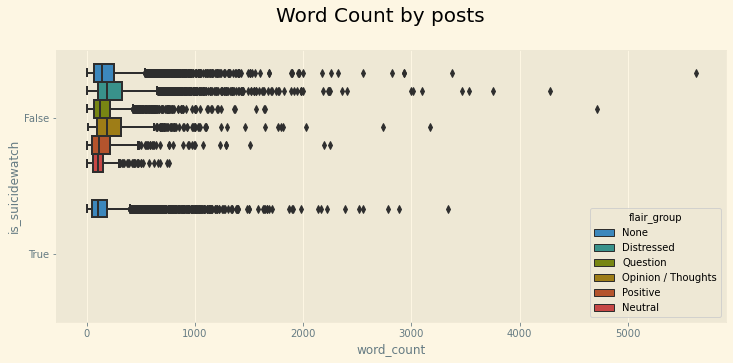

In [19]:
f, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(data = df_combine, 
            x='word_count',
            y='is_suicidewatch', 
            hue='flair_group',
           orient='h')
f.suptitle('Word Count by posts', fontsize=20,y=1.0);

We note that posts from r/SuicideWatch tend to have lower number of posts, but there isnt a clear pattern among the flair groups in r/MentalHealth, hence word count this might not be too useful in classification either.

In [20]:
# create stop word list 
stopwordlist = nltk.corpus.stopwords.words('english')

In [21]:
custom_stopwords = stopwordlist + ['suicide','mental','health','reddit','subreddit']

#### Text analysis

Given that we do not see much meaningful information from numerical data, we now seek to analyze the post text to see if we can get any insights.

#### CountVectorizer unigrams

In [82]:
# Set up X and Y
X = df_combine['clean_alltext']
y = df_combine['is_suicidewatch']

In [83]:
# Instantiate a CountVectorizer
cvec = CountVectorizer(
    stop_words= custom_stopwords,
    strip_accents = 'ascii',
    max_features = 5000,
    max_df = 0.9,
    min_df = 0.1,
    ngram_range= (1,1)
)


In [84]:
# Fit the vectorizer on our corpus.
cvec.fit(X)
# Transform the corpus.
X_t = cvec.transform(X)
# Save result to dataframe
X_df = pd.DataFrame(X_t.todense(), columns=cvec.get_feature_names())
#adding the target values to the DataFrame
common_words = pd.concat([y, X_df], axis = 1)

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


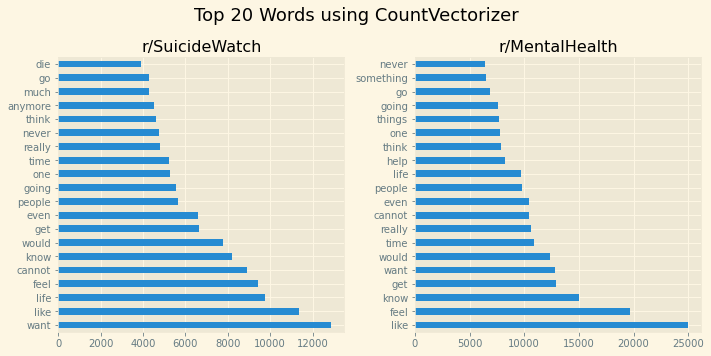

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

common_words[common_words['is_suicidewatch']==1] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax1)

ax1.set_title(f'r/SuicideWatch')

common_words[common_words['is_suicidewatch']==0] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax2)

ax2.set_title(f'r/MentalHealth')

plt.suptitle('Top 20 Unigrams using CountVectorizer', fontsize=18)
plt.tight_layout()

In [89]:
# Get top 20 unigrams for r/SuicideWatch
top_words_sw = common_words[common_words['is_suicidewatch']==1] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).index

In [90]:
# Get top 20 unigrams for r/MentalHealth
top_words_mh = common_words[common_words['is_suicidewatch']==0] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).index

In [99]:
# generate unigrams that are not repeated across both top 20 lists 
unique = set(list(top_words_sw) + list(top_words_mh))
print(unique)
print(f'There are {len(set(top_words_sw + top_words_mh))} unique words in the top 20 list') 

{'feel', 'know', 'would', 'get', 'even', 'never', 'die', 'cannot', 'something', 'people', 'think', 'one', 'help', 'things', 'really', 'much', 'go', 'time', 'like', 'life', 'want', 'going', 'anymore'}
There are 20 unique words in the top 20 list


We see that half words in both top unigrams lists are overlapping. We will now try TFIDFVectorizer to see if we get a more differentiated result.

#### TfidfVectorizer unigrams

In [100]:
# Set up X and Y
X = df_combine['clean_alltext']
y = df_combine['is_suicidewatch']

In [101]:
# Instantiate a TFIDFVectorizer
# max_df = 0.9 and min_df = 0.1 only gives 1 bigrams
# max_df = 0.95 and min_df = 0.05 only gives 3 bigrams
# common bigrams are rare
tvec = TfidfVectorizer(
    stop_words= custom_stopwords,
    strip_accents = 'ascii',
    max_features = 5000,
    max_df = 0.9,
    min_df = 0.1,
    ngram_range= (1,1)
)

In [102]:
# Fit the vectorizer on our corpus.
tvec.fit(X)
# Transform the corpus.
X_t = tvec.transform(X)
# Save result to dataframe
X_df = pd.DataFrame(X_t.todense(), columns=tvec.get_feature_names())
# Adding the target values to the DataFrame
common_words = pd.concat([y, X_df], axis = 1)

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


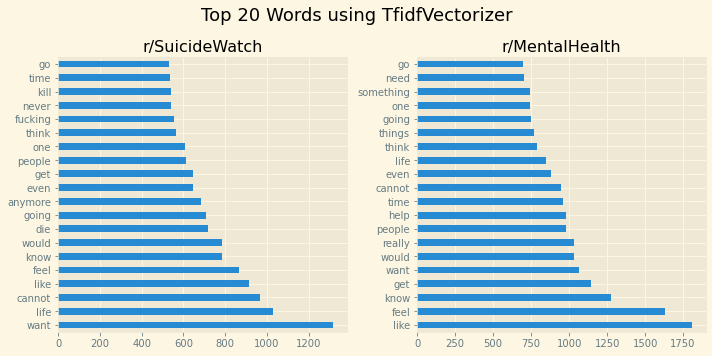

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

common_words[common_words['is_suicidewatch']==1] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax1)

ax1.set_title(f'r/SuicideWatch')

common_words[common_words['is_suicidewatch']==0] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax2)

ax2.set_title(f'r/MentalHealth')

plt.suptitle('Top 20 Words using TfidfVectorizer', fontsize=18)
plt.tight_layout()

In [104]:
# Get top 20 words for r/SuicideWatch
top_words_sw = common_words[common_words['is_suicidewatch']==1] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).index

In [105]:
# Get top 20 words for r/MentalHealth
top_words_mh = common_words[common_words['is_suicidewatch']==0] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).index

In [106]:
# generate words that are not repeated across both top 20 lists 
unique = set(list(top_words_sw) + list(top_words_mh))
print(unique)
print(f'There are {len(set(top_words_sw + top_words_mh))} unique words in the top 20 list') 

{'feel', 'know', 'would', 'even', 'get', 'never', 'die', 'cannot', 'fucking', 'something', 'people', 'think', 'one', 'help', 'things', 'really', 'go', 'time', 'like', 'life', 'want', 'going', 'need', 'anymore', 'kill'}
There are 20 unique words in the top 20 list


The number of overlapping unigrams for TFIDFVectorizer is the same. Hence the improvement in results from using unigrams in our

#### CountVectorizer bigram and trigrams

In [109]:
# Instantiate a CountVectorizer
cvec = CountVectorizer(
    stop_words= custom_stopwords,
    strip_accents = 'ascii',
    max_features = 5000,
    max_df = 0.97,
    min_df = 0.03,
    ngram_range= (2,3)
)

In [110]:
# Fit the vectorizer on our corpus.
cvec.fit(X)
# Transform the corpus.
X_t = cvec.transform(X)
# Save result to dataframe
X_df = pd.DataFrame(X_t.todense(), columns=cvec.get_feature_names())
# Adding the target values to the DataFrame
common_words = pd.concat([y, X_df], axis = 1)

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


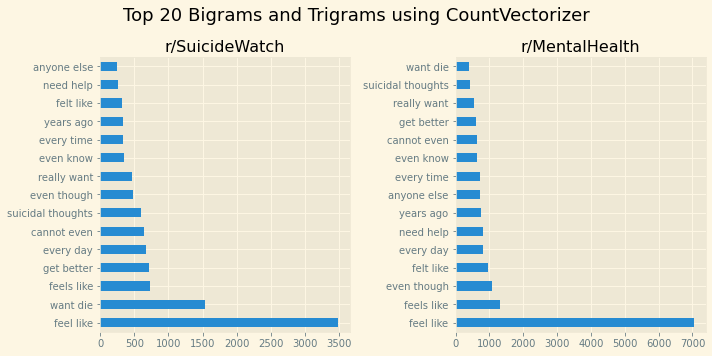

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

common_words[common_words['is_suicidewatch']==1] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax1)

ax1.set_title(f'r/SuicideWatch')

common_words[common_words['is_suicidewatch']==0] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax2)

ax2.set_title(f'r/MentalHealth')

plt.suptitle('Top 20 Bigrams and Trigrams using CountVectorizer', fontsize=18)
plt.tight_layout()

In [112]:
# Get top 20 words for r/SuicideWatch
top_words_sw = common_words[common_words['is_suicidewatch']==1] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).index

In [113]:
# Get top 20 words for r/MentalHealth
top_words_mh = common_words[common_words['is_suicidewatch']==0] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).index

In [114]:
# generate words that are not repeated across both top 20 lists 
unique = set(list(top_words_sw) + list(top_words_mh))
print(unique)
print(f'There are {len(set(top_words_sw + top_words_mh))} unique words in the top 20 list') 

{'felt like', 'really want', 'want die', 'anyone else', 'suicidal thoughts', 'need help', 'even know', 'every day', 'get better', 'feel like', 'feels like', 'every time', 'years ago', 'even though', 'cannot even'}
There are 15 unique words in the top 20 list


#### TFIDFVectorizer bigram and trigrams

In [122]:
# Instantiate a TFIDFVectorizer
# max_df = 0.9 and min_df = 0.1 only gives 1 bigrams
# max_df = 0.95 and min_df = 0.05 only gives 3 bigrams
# common bigrams are rare
tvec = TfidfVectorizer(
    stop_words= custom_stopwords,
    strip_accents = 'ascii',
    max_features = 5000,
    max_df = 0.97,
    min_df = 0.03,
    ngram_range= (2,3)
)

In [123]:
# Fit the vectorizer on our corpus.
tvec.fit(X)
# Transform the corpus.
X_t = tvec.transform(X)
# Save result to dataframe
X_df = pd.DataFrame(X_t.todense(), columns=tvec.get_feature_names())
# Adding the target values to the DataFrame
common_words = pd.concat([y, X_df], axis = 1)

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


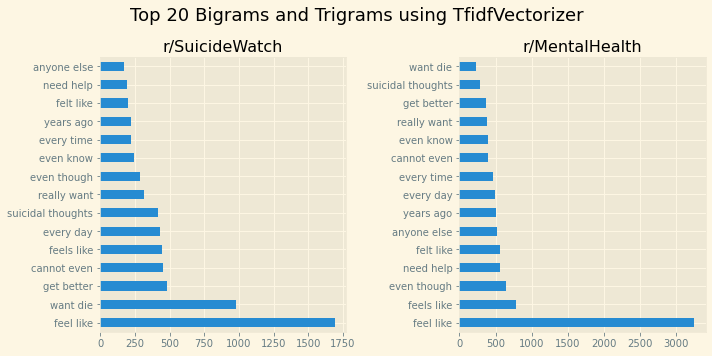

In [124]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

common_words[common_words['is_suicidewatch']==1] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax1)

ax1.set_title(f'r/SuicideWatch')

common_words[common_words['is_suicidewatch']==0] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax2)

ax2.set_title(f'r/MentalHealth')

plt.suptitle('Top 20 Bigrams and Trigrams using TfidfVectorizer', fontsize=18)
plt.tight_layout()

In [125]:
# Get top 20 words for r/SuicideWatch
top_words_sw = common_words[common_words['is_suicidewatch']==1] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).index

In [126]:
# Get top 20 words for r/MentalHealth
top_words_mh = common_words[common_words['is_suicidewatch']==0] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).index

In [127]:
# generate words that are not repeated across both top 20 lists 
unique = set(list(top_words_sw) + list(top_words_mh))
print(unique)
print(f'There are {len(set(top_words_sw + top_words_mh))} unique words in the top 20 list') 

{'felt like', 'really want', 'want die', 'anyone else', 'suicidal thoughts', 'need help', 'even know', 'every day', 'get better', 'feel like', 'feels like', 'every time', 'years ago', 'even though', 'cannot even'}
There are 15 unique words in the top 20 list


There is more overlap in the bigrams of the top 20 words in each subreddit compared to unigrams. Hence this would be less useful in a classification model than unigrams.

#### CountVectorizer lemmatized bigram and trigrams

In [129]:
# Instantiate lemmatizer.
lemmatizer = WordNetLemmatizer()

# define function that takes in words from paragraph, and lemmitize and join back as paragraph
def lem_words(text):
    return ' '.join([lemmatizer.lemmatize(i) for i in text.split(' ')])

# Create lemmatized version of clean_alltext
df_combine['clean_alltext_lem'] = df_combine['clean_alltext'].map(lambda x: lem_words(x))

In [171]:
# Set up X and Y
X = df_combine['clean_alltext_lem']
y = df_combine['is_suicidewatch']

In [178]:
# Instantiate a CountVectorizer
cvec = CountVectorizer(
    stop_words= custom_stopwords,
    strip_accents = 'ascii',
    max_features = 5000,
    max_df = 0.97,
    min_df = 0.03,
    ngram_range= (2,3)
)

In [179]:
# Fit the vectorizer on our corpus.
cvec.fit(X)
# Transform the corpus.
X_t = cvec.transform(X)
# Save result to dataframe
X_df = pd.DataFrame(X_t.todense(), columns=cvec.get_feature_names())
# Adding the target values to the DataFrame
common_words = pd.concat([y, X_df], axis = 1)

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


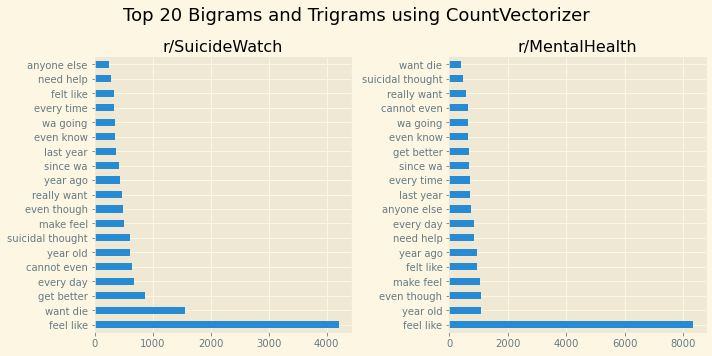

In [180]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

common_words[common_words['is_suicidewatch']==1] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax1)

ax1.set_title(f'r/SuicideWatch')

common_words[common_words['is_suicidewatch']==0] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax2)

ax2.set_title(f'r/MentalHealth')

plt.suptitle('Top 20 Bigrams and Trigrams using CountVectorizer', fontsize=18)
plt.tight_layout()

In [181]:
# Get top 20 words for r/SuicideWatch
top_words_sw = common_words[common_words['is_suicidewatch']==1] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).index

In [182]:
# Get top 20 words for r/MentalHealth
top_words_mh = common_words[common_words['is_suicidewatch']==0] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).index

In [183]:
# generate words that are not repeated across both top 20 lists 
unique = set(list(top_words_sw) + list(top_words_mh))
print(unique)
print(f'There are {len(set(top_words_sw + top_words_mh))} unique words in the top 20 list') 

{'last year', 'year ago', 'every day', 'get better', 'feel like', 'cannot even', 'felt like', 'every time', 'wa going', 'even though', 'really want', 'even know', 'make feel', 'since wa', 'year old', 'want die', 'anyone else', 'need help', 'suicidal thought'}
There are 19 unique words in the top 20 list


#### TFIDFVectorizer lemmatized bigram and trigrams

In [172]:
# Instantiate a TFIDFVectorizer
# max_df = 0.9 and min_df = 0.1 only gives 1 bigrams
# max_df = 0.95 and min_df = 0.05 only gives 3 bigrams
# common bigrams are rare
tvec = TfidfVectorizer(
    stop_words= custom_stopwords,
    strip_accents = 'ascii',
    max_features = 5000,
    max_df = 0.97,
    min_df = 0.03,
    ngram_range= (2,3)
)

In [173]:
# Fit the vectorizer on our corpus.
tvec.fit(X)
# Transform the corpus.
X_t = tvec.transform(X)
# Save result to dataframe
X_df = pd.DataFrame(X_t.todense(), columns=tvec.get_feature_names())
# Adding the target values to the DataFrame
common_words = pd.concat([y, X_df], axis = 1)

C:\Users\deang\anaconda3\envs\dsi\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


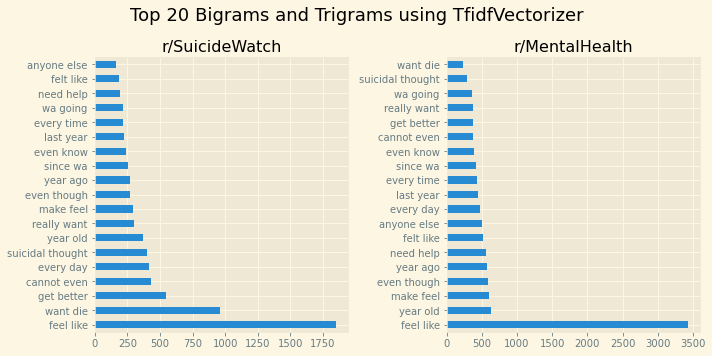

In [174]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

common_words[common_words['is_suicidewatch']==1] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax1)

ax1.set_title(f'r/SuicideWatch')

common_words[common_words['is_suicidewatch']==0] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).plot(kind='barh', ax=ax2)

ax2.set_title(f'r/MentalHealth')

plt.suptitle('Top 20 Bigrams and Trigrams using TfidfVectorizer', fontsize=18)
plt.tight_layout()

In [175]:
# Get top 20 words for r/SuicideWatch
top_words_sw = common_words[common_words['is_suicidewatch']==1] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).index

In [176]:
# Get top 20 words for r/MentalHealth
top_words_mh = common_words[common_words['is_suicidewatch']==0] \
    .drop(columns='is_suicidewatch') \
    .sum().sort_values(ascending=False).head(20).index

In [177]:
# generate words that are not repeated across both top 20 lists 
unique = set(list(top_words_sw) + list(top_words_mh))
print(unique)
print(f'There are {len(set(top_words_sw + top_words_mh))} unique words in the top 20 list') 

{'last year', 'year ago', 'every day', 'get better', 'feel like', 'cannot even', 'felt like', 'every time', 'wa going', 'even though', 'really want', 'even know', 'make feel', 'since wa', 'year old', 'want die', 'anyone else', 'need help', 'suicidal thought'}
There are 19 unique words in the top 20 list


Lemmaziting increased number of unique Bigrams by four, but still one less than vectorizing using unlemmatized unigrams. Hence its likely that categorical modelling using unlemmatized unigrams would produce better results, so we won't use lemmatizing in our models.